# Predicting Peak Usage on a Minecraft Research Server

## Introduction

A research group in Computer Science at UBC which is led by Frank Wood is studying how people play Minecraft. They have set up a special Minecraft server that tracks when players join and leave. Since running the server requires resources such as server space and licenses, they want to ensure they have enough resources when the most people are playing.

In this project, we will try to find patterns about when players are most active. If we can find which times of the day are the busiest, the research team can better plan when to prepare more server resources. In particular, we will address the question: Can we predict the level of activity on the Minecraft server based on the day of the week and time of day?

There are two available files: "player.csv" and "sessions.csv". The file we are going to use is called "sessions.csv". It has 1535 observations with 5 variables. The following table is a basic summary:

| Variable Name         | Type   | Description                                          |
| --------------------- | ------ | ---------------------------------------------------- |
| `hashedEmail`         | chr    | A unique ID for each player |
| `start_time`          | chr | The start date and time of each player             |
| `end_time`            | chr | The start date and time of each player               |
| `original_start_time` | dbl  | Start time in milliseconds       |
| `original_end_time`   | dbl  | End time in milliseconds         |


Since we are interested in demand forecasting, we will use the `start_time` column to see when people usually start playing Minecraft.

In [118]:
library(tidyverse)
library(repr)
library(readxl)
source("cleanup.R")
options(repr.matrix.max.rows = 6)

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [119]:
session <- read_csv("sessions.csv") |>
            select(start_time)
session

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


start_time
<chr>
30/06/2024 18:12
17/06/2024 23:33
25/07/2024 17:34
25/07/2024 03:22
25/05/2024 16:01
23/06/2024 15:08
15/04/2024 07:12
21/09/2024 02:13
21/06/2024 02:31


## Method & Results

We want to predict the time windows with the most people on each day of the week. However, `start_time` contains date-time values stored as character strings which makes it hard to process. Fortunately, the string has a tidy format with day first, month second, year last, followed by hour and minute. This allows us to use `dmy_hm()` function to convert it into a date-time object.  

Once it is converted, we can then extract the start hour with `hour()` function and the day with `weekdays()` function. To make it simpler, we will not include minutes in the time window. In the end, we use `filter` to get rid of any `NA` values.

In [122]:
session_new <- session |>
  mutate(
    start_time = dmy_hm(start_time),
    start_hour = hour(start_time),
    day = weekdays(start_time)
  ) |>
  filter(!is.na(start_hour)) 
session_new

start_time,start_hour,day
<dttm>,<int>,<chr>
2024-06-30 18:12:00,18,Sunday
2024-06-17 23:33:00,23,Monday
2024-07-25 17:34:00,17,Thursday
2024-07-25 03:22:00,3,Thursday
2024-05-25 16:01:00,16,Saturday
2024-06-23 15:08:00,15,Sunday
2024-04-15 07:12:00,7,Monday
2024-09-21 02:13:00,2,Saturday
2024-06-21 02:31:00,2,Friday


Now we already have the numerical value for `start_hour`. We can start visualizing the data points. We will create a histogram to show the distribution of the start time of Minecraft.

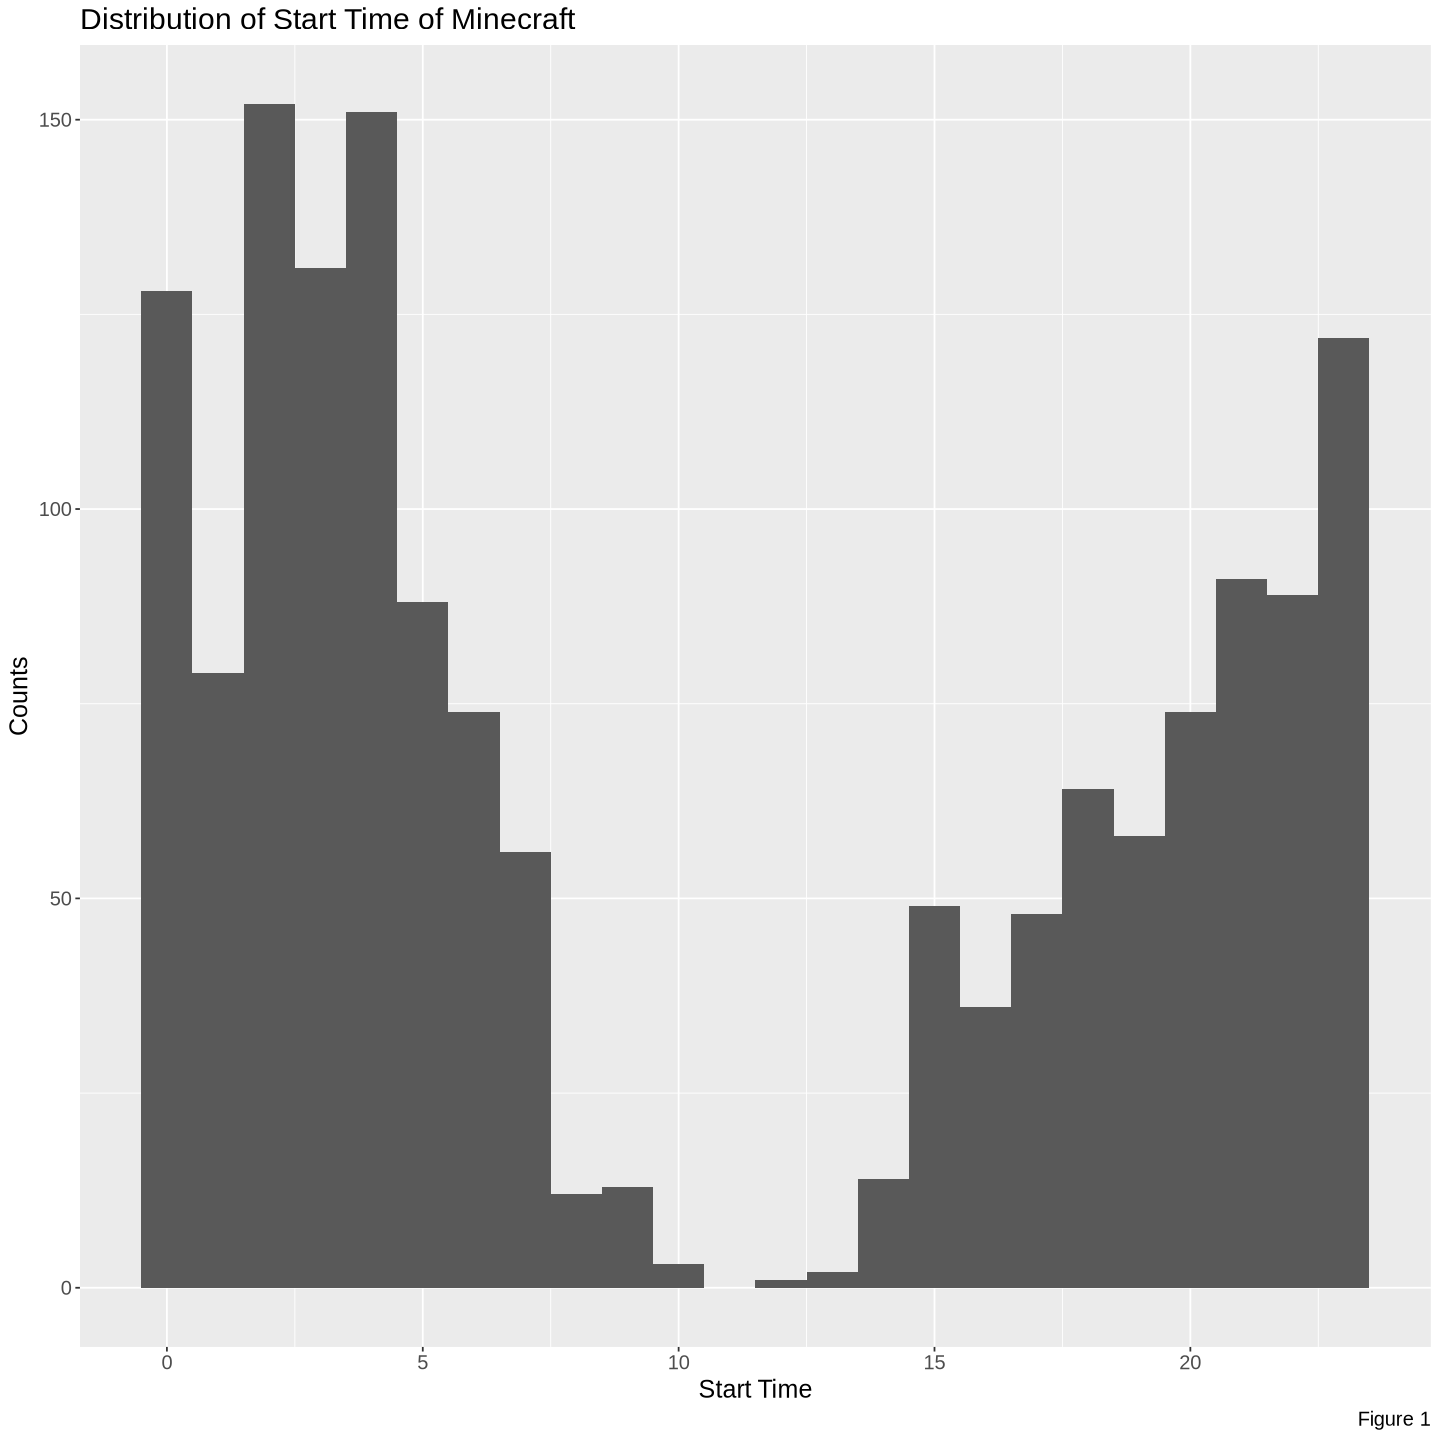

In [163]:
options(repr.plot.width = 12, repr.plot.height = 12) 
time_plot_1 <- ggplot(session_new,
                      aes(x = start_hour)) +
  geom_histogram(binwidth = 1) +
  labs(x = "Start Time",
       y = "Counts",
       caption = "Figure 1",
      title = "Distribution of Start Time of Minecraft") +
  theme(text = element_text(size = 15)) 
time_plot_1

We will also count the total number of starts each day to compare the level of activity on the Minecraft server each day. To accomplish this, we will use the `group_by()` function to group the data based on `day` and then use `summarize` to count

In [160]:
day_starts <- session_new |> group_by(day) |>
  summarize(starts = n())
day_starts

day,starts
<chr>,<int>
Friday,181
Monday,207
Saturday,261
Sunday,249
Thursday,223
Tuesday,204
Wednesday,210


Then we will create a bar chart to visualize the difference. 

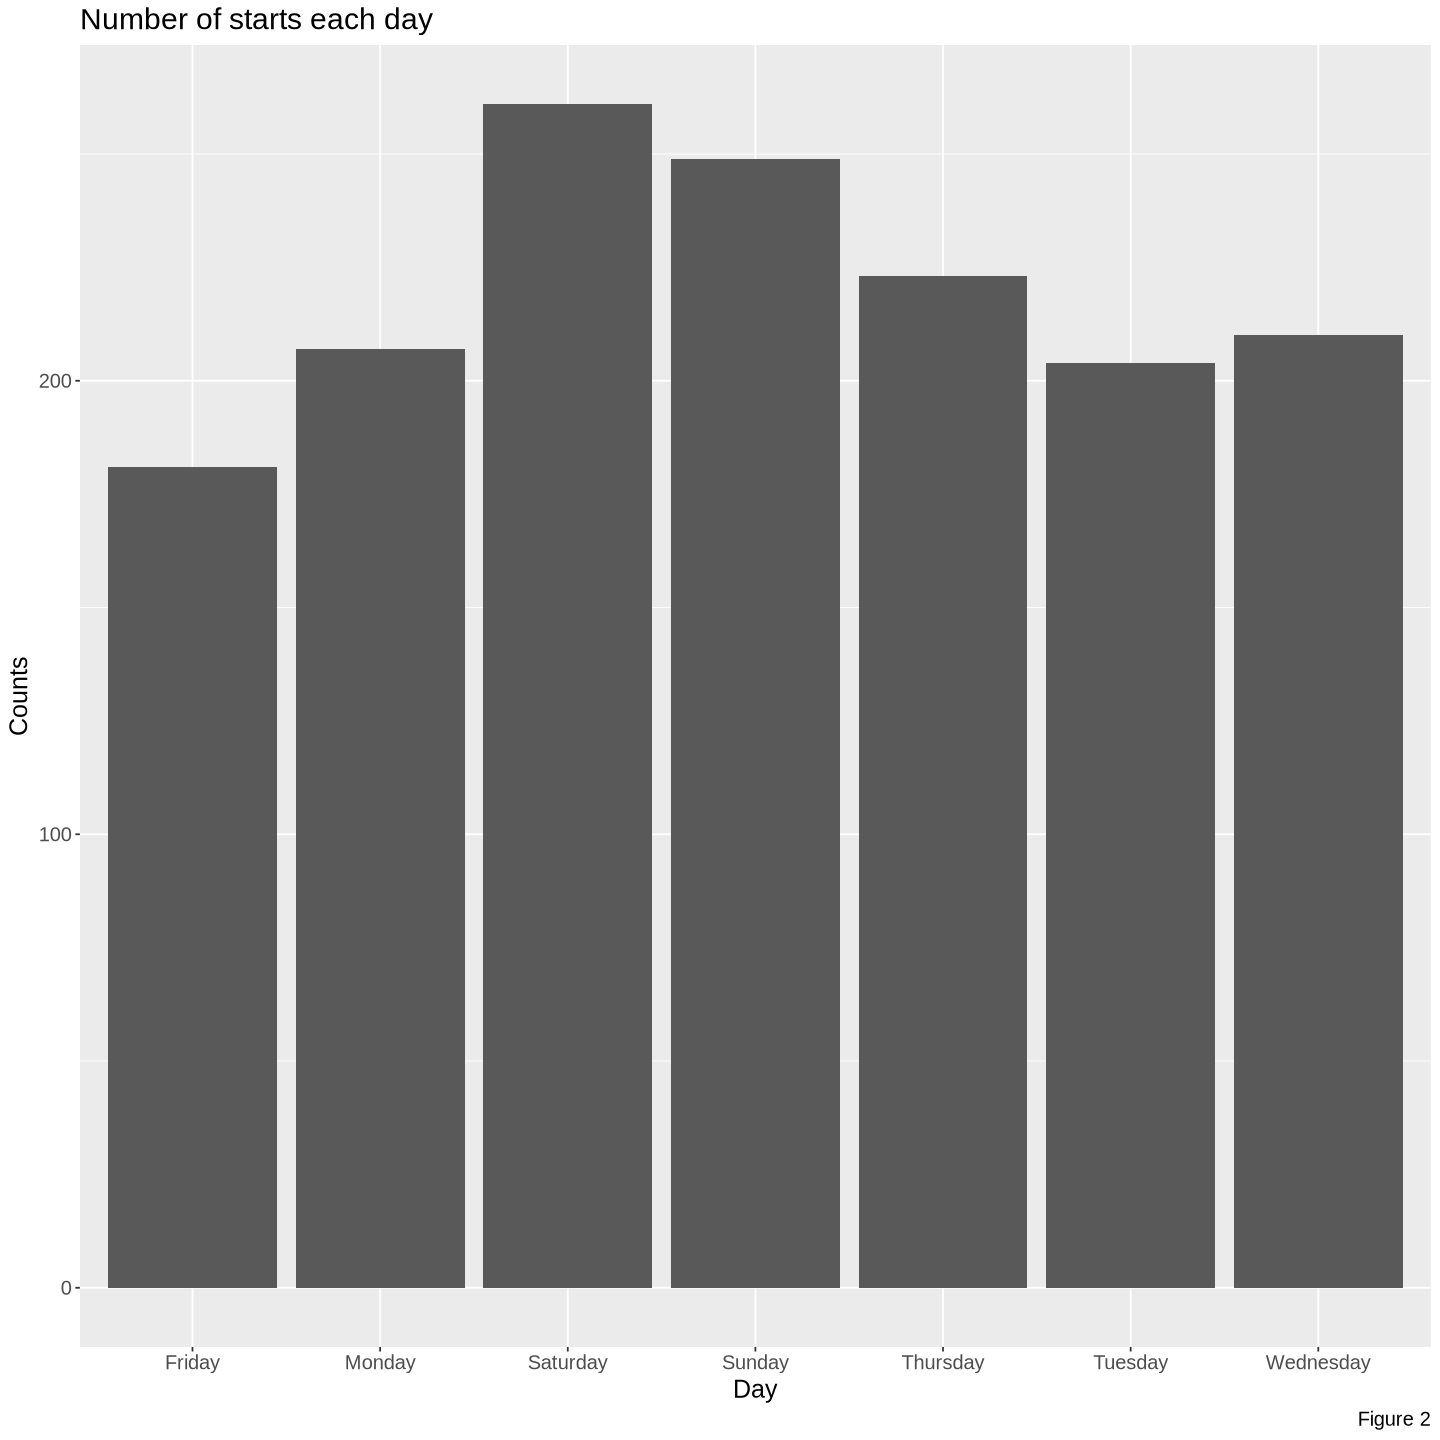

In [162]:
options(repr.plot.width = 12, repr.plot.height = 12) 
time_plot_2 <- ggplot(day_starts,
                      aes(x = day,
                          y = starts)) +
  geom_bar(stat = "identity") +
  labs(x = "Day",
       y = "Counts",
       caption = "Figure 2",
      title = "Number of starts each day") +
  theme(text = element_text(size = 15))
time_plot_2

Finally, we will create a histogram of time distribution with 7 subplots for each day for overall comparison.

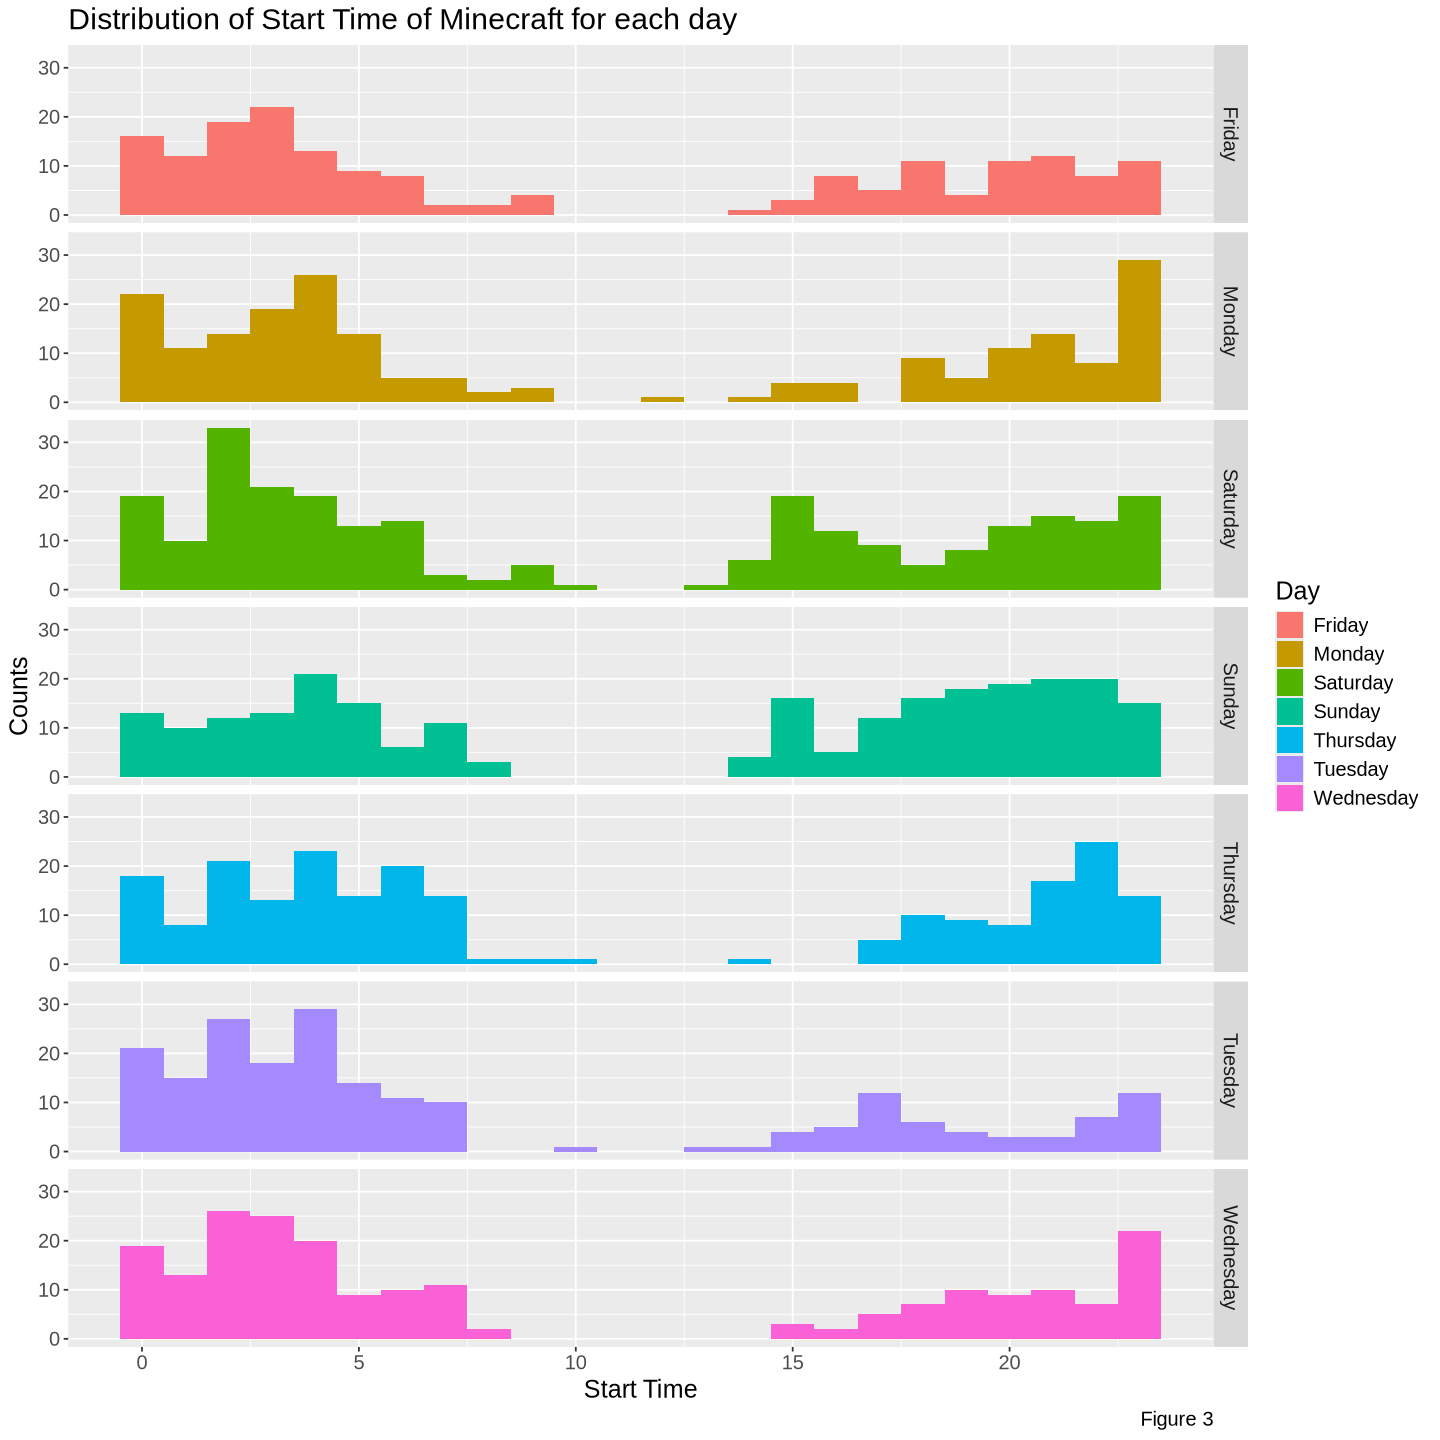

In [172]:
time_plot_3 <- ggplot(session_new,
                      aes(x = start_hour,
                         fill = day)) +
  geom_histogram(binwidth = 1) +
  facet_grid(row = vars(day))+
  labs(x = "Start Time",
       y = "Counts",
       fill = "Day",
       caption = "Figure 3",
       title = "Distribution of Start Time of Minecraft for each day") +
  theme(text = element_text(size = 15)) 
time_plot_3

## Discussion

From the start time distribution, we see that most of the start hours are from 2:00 a.m. to 4:00 a.m. and fewer start hours are from 8:00 a.m. to 2:00 p.m.. 

In [ ]:
From the day bar chart, we see that the highest number of starts is on Saturday while the . From the last figure, 